In [1]:
import os
import sys
os.environ["OMP_NUM_THREADS"] = "11"
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "11" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "11" # export NUMEXPR_NUM_THREADS=6
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse as sps
import h5py

import scvi
import scanpy as sc
import scipy.io as sio

import matplotlib.pyplot as plt
from os.path import join

Global seed set to 0


In [2]:
import scipy
from sklearn.metrics import roc_auc_score
def pearson_mat(X, Y):
    X = (X - X.mean(axis=0))
    X /= (scipy.linalg.norm(X, axis=0, ord=2) + 1e-12)
    Y = (Y - Y.mean(axis=0))
    Y /= (scipy.linalg.norm(Y, axis=0, ord=2) + 1e-12)
    return (X * Y).sum(axis=0)

def eval_pearRmse_AlongGene(X, Y):
    pear = pearson_mat(X, Y)
    rmse = np.sqrt(np.mean((X-Y)**2, axis=0))
    return pear, rmse

def eval_spear_AlongGene(X, Y):
    spears = []
    for gi in range(X.shape[1]):
        spears.append(scipy.stats.spearmanr(X[:, gi], Y[:, gi])[0])
    return spears

def eval_aucRmse_AlongPeak(X, Y):
    aucs, rmses = [], []
    for pi in range(X.shape[1]):
        aucs.append(roc_auc_score(X[:, pi], Y[:, pi]))
        rmses.append(
            np.sqrt(np.mean((X[:, pi] - Y[:, pi])**2))
        )
    return aucs, rmses

def eval_imputation_flatten(x, y):
    pearson_r, pearson_p = scipy.stats.pearsonr(x, y)
    print(f"Found pearson's correlation/p of {pearson_r:.4f}/{pearson_p:.4g}")
    spearman_corr, spearman_p = scipy.stats.spearmanr(x, y)
    print(f"Found spearman's collelation/p of {spearman_corr:.4f}/{spearman_p:.4g}")
    rmse = np.sqrt(np.mean((x - y)**2))
    print(f"Found rmse {rmse:.4f}")
    return pearson_r, spearman_corr, rmse

In [3]:
root_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/'
dataset_path = os.path.join(
    root_dir, 
    'output/datasets/match_modality/openproblems_bmmc_multiome_phase2_rna/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_')

par = {
    'input_train_mod1': f'{dataset_path}train_mod1.h5ad',
    'input_train_mod2': f'{dataset_path}train_mod2.h5ad',
    'input_train_sol': f'{dataset_path}train_sol.h5ad',
    'input_test_sol': f'{dataset_path}test_sol.h5ad',
    'input_test_mod1': f'{dataset_path}test_mod1.h5ad',
    'input_test_mod2': f'{dataset_path}test_mod2.h5ad',
}

print('Reading `h5ad` files...')
input_train_mod1 = sc.read_h5ad(par['input_train_mod1'])
input_train_mod2 = sc.read_h5ad(par['input_train_mod2'])
input_train_sol = sc.read_h5ad(par['input_train_sol'])
input_test_mod1 = sc.read_h5ad(par['input_test_mod1'])
input_test_mod2 = sc.read_h5ad(par['input_test_mod2'])

mod1_feature_type = set(input_train_mod1.var["feature_types"])
mod2_feature_type = set(input_train_mod2.var["feature_types"])
assert len(mod1_feature_type) == len(mod2_feature_type) == 1
mod1_feature_type = mod1_feature_type.pop()
mod2_feature_type = mod2_feature_type.pop()

print("Unscrambling training cells...")
ord = input_train_sol.X.tocsr().indices
if "pairing_ix" in input_train_sol.uns:
    assert np.all(ord == np.argsort(input_train_sol.uns["pairing_ix"]))
input_train_mod2 = input_train_mod2[ord, :].copy()
input_train_mod2.obs_names = input_train_mod1.obs_names
input_train_mod1.obs["uid"] = [f"train-{i}" for i in range(input_train_mod1.shape[0])]
input_train_mod2.obs["uid"] = [f"train-{i}" for i in range(input_train_mod2.shape[0])]
assert np.all(input_train_mod1.obs["batch"] == input_train_mod2.obs["batch"])

input_test_sol = sc.read_h5ad(par['input_test_sol'])
ord = input_test_sol.X.tocsr().indices
if "pairing_ix" in input_test_sol.uns:
    assert np.all(ord == np.argsort(input_test_sol.uns["pairing_ix"]))
input_test_mod2 = input_test_mod2[ord, :].copy()
input_test_mod2.obs_names = input_test_mod1.obs_names    

if mod1_feature_type == "GEX":
    gex = input_train_mod1
    other = input_train_mod2
    gex_test = input_test_mod1
    other_test = input_test_mod2
else:
    gex = input_train_mod2
    other = input_train_mod1
    gex_test = input_test_mod2
    other_test = input_test_mod1

# rename to be consistent with meta data
def renames(df):
    df['full_names'] = df.index.to_numpy()
    df.index = [_.split('-')[0]+'-'+_.split('-')[1] for _ in df.index]
    return df

gex.obs = renames(gex.obs)
gex_test.obs = renames(gex_test.obs)

other.obs = renames(other.obs)
other_test.obs = renames(other_test.obs)

df_meta = pd.read_csv(os.path.join(root_dir, 'output/datasets/multiome_meta.csv'), index_col=0)
df_meta = renames(df_meta)

train_idx = ~df_meta.batch.isin(['s4d1', 's4d8', 's4d9'])
test_idx  = df_meta.batch.isin(['s4d1', 's4d8', 's4d9'])
gex.obs[['batch', 'cell_type']] = df_meta.loc[train_idx].loc[gex.obs_names, ['batch', 'cell_type']].copy()
gex_test.obs[['batch', 'cell_type']] = df_meta.loc[test_idx].loc[gex_test.obs_names, ['batch', 'cell_type']].copy()
other.obs[['batch', 'cell_type']] = df_meta.loc[train_idx].loc[other.obs_names, ['batch', 'cell_type']].copy()
other_test.obs[['batch', 'cell_type']] = df_meta.loc[test_idx].loc[other_test.obs_names, ['batch', 'cell_type']].copy()

# pick peak startwith chr1-23
atac_names = other.var_names.to_numpy()
valid_atac_idx = [
    _ for _ in range(len(atac_names)) 
    if atac_names[_].startswith('chr') and 
    not atac_names[_].startswith('chrX-') and 
    not atac_names[_].startswith('chrY-')
]
valid_atac_names = atac_names[valid_atac_idx]
other = other[:, valid_atac_names].copy()
other_test = other_test[:, valid_atac_names].copy()

# hvg and hvp
sc.pp.highly_variable_genes(gex, n_top_genes=5000)
hvg_idx = np.where(gex.var.highly_variable)[0]
gex = gex[:, hvg_idx].copy()
gex_test = gex_test[:, hvg_idx].copy()

hvp_idx = np.argsort(other.X.sum(axis=0).A1)[-20000:]
hvp_names = valid_atac_names[hvp_idx]

other = other[:, hvp_idx].copy()
other_test = other_test[:, hvp_idx].copy()

Reading `h5ad` files...
Unscrambling training cells...


In [4]:
mult_X = gex.X.A
mult_Y = other.X.A
single_X  = gex_test.X.A
single_Y  = other_test.X.A

# mult_XY = np.hstack([mult_X, mult_Y])

In [5]:
adata_paired = sc.AnnData(np.c_[mult_X, mult_Y])
# adata_paired.obs['batch'] = gex.obs.batch.to_numpy()
adata_paired.var['modality'] = ['gene']*hvg_idx.size + ['peak']*hvp_idx.size

adata_rna = sc.AnnData(np.c_[mult_X, np.zeros_like(mult_Y)])
# adata_rna.obs['batch'] = gex.obs.batch.to_numpy()
adata_rna.var['modality'] = ['gene']*hvg_idx.size + ['peak']*hvp_idx.size

adata_atac = sc.AnnData(np.c_[np.zeros_like(mult_X), mult_Y])
# adata_atac.obs['batch'] = gex.obs.batch.to_numpy()
adata_atac.var['modality'] = ['gene']*hvg_idx.size + ['peak']*hvp_idx.size

adata = scvi.data.organize_multiome_anndatas(adata_paired, adata_rna, adata_atac)

import gc
del adata_atac, adata_rna, adata_paired
gc.collect()

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


977

In [6]:
scvi.model.MULTIVI.setup_anndata(
    adata, 
    batch_key="modality",
#     continuous_covariate_keys=['batch']
)

vae = scvi.model.MULTIVI(
    adata, n_latent=32, gene_likelihood='nb',
    n_genes=hvg_idx.size,
    n_regions=hvp_idx.size,
)

# vae.train(
#    train_size=0.9,
#    early_stopping=15
# )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
# vae.save('./MultiVI_checkpoint/multiome', overwrite=True)

vae = scvi.model.MULTIVI.load('./MultiVI_checkpoint/multiome', adata)

# ATAC->RNA

In [8]:
adata_test = sc.AnnData(np.c_[np.zeros_like(single_X), single_Y])
adata_test.var['modality'] = ['gene']*hvg_idx.size + ['peak']*hvp_idx.size
adata_test.obs['modality'] = ['accessibility'] * single_Y.shape[0]

imputed_expr = vae.get_normalized_expression(adata_test)
X_hat = np.log1p(imputed_expr.values * 1e4)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scvi/module/_multivae.py:567: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


In [52]:
pr, sr, rmse = eval_imputation_flatten(single_X.flatten(), X_hat.flatten())
pear_along_gene, rmse_along_gene = eval_pearRmse_AlongGene(single_X, X_hat)
spear_along_gene = eval_spear_AlongGene(single_X, X_hat)

np.mean(pear_along_gene), np.mean(spear_along_gene) #, np.mean(rmse_along_gene)

Found pearson's correlation/p of 0.3232/0
Found spearman's collelation/p of 0.2386/0
Found rmse 0.9760


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(0.12841868, nan)

# RNA->ATAC

In [9]:
adata_test = sc.AnnData(np.c_[single_X, np.zeros_like(single_Y)])
adata_test.var['modality'] = ['gene']*hvg_idx.size + ['peak']*hvp_idx.size
adata_test.obs['modality'] = ['expression'] * single_X.shape[0]

imputed_expr = vae.get_accessibility_estimates(adata_test)
Y_hat = imputed_expr.values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [18]:
auc = roc_auc_score(single_Y.flatten(), Y_hat.flatten())

auc_along_peak, rmse_along_peak = eval_aucRmse_AlongPeak(single_Y, Y_hat)
auc, np.mean(auc_along_peak) #, np.mean(rmse_along_peak)

(0.7252441248359456, 0.6074440506907394)

# Vis

In [14]:
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import randomized_svd
def get_rna_umap(adata):
    X = adata.X.A if sps.issparse(adata.X) else adata.X
    u, s, vh = randomized_svd(X, 50, n_iter=15, random_state=0)
    X_lsi = X @ vh.T / s
    X_lsi -= X_lsi.mean(axis=1, keepdims=True)
    X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)
    adata.obsm['X_lsi'] = X_lsi
    sc.pp.neighbors(adata, use_rep='X_lsi', n_neighbors=15)
    sc.tl.umap(adata)
    return adata

def get_atac_umap(adata):
    X = adata.X.copy()
    if scipy.sparse.issparse(X):
        idf = X.shape[0] / (1e-12 + X.sum(axis=0).A1)
        tf = X.multiply(1 / (1e-12 + X.sum(axis=1)))
        X = tf.multiply(idf)
        X = X.multiply(1e4 / (1e-12 + X.sum(axis=1)))
    else:
        idf = X.shape[0] / (1e-12 + X.sum(axis=0))
        tf = X / (1e-12 + X.sum(axis=1, keepdims=True))
        X = tf * idf
        X = X * (1e4 / (1e-12 + X.sum(axis=1, keepdims=True)))
    X = np.log1p(X)
    u, s, vh = randomized_svd(X, 50, n_iter=15, random_state=0)
    X_lsi = X @ vh.T / s
    X_lsi -= X_lsi.mean(axis=1, keepdims=True)
    X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)
    adata.obsm['X_lsi'] = X_lsi
    sc.pp.neighbors(adata, use_rep='X_lsi', n_neighbors=15)
    sc.tl.umap(adata)
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)


In [11]:
gex_test.X.max(), other_test.X.max()

(7.6440573, 1.0)

In [15]:
ad_rna_imputed = sc.AnnData(X_hat, obs=gex_test.obs)
ad_atac_imputed = sc.AnnData(Y_hat, obs=other_test.obs)

ad_rna_imputed = get_rna_umap(ad_rna_imputed)
ad_atac_imputed = get_atac_umap(ad_atac_imputed)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [16]:
X_hat.max(), Y_hat.max()

(5.262681, 0.9992908)

In [17]:
ad_rna_concat = sc.AnnData(
    np.r_[gex_test.X.A, X_hat], 
    obs=pd.concat([gex_test.obs, gex_test.obs])
)
ad_atac_concat = sc.AnnData(
    np.r_[other_test.X.A, Y_hat], 
    obs=pd.concat([other_test.obs, other_test.obs])
)

ad_rna_concat = get_rna_umap(ad_rna_concat)
ad_atac_concat = get_atac_umap(ad_atac_concat)

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
ad_rna_concat.obs['mod'] = ['truth'] * gex_test.shape[0] + ['pred'] * gex_test.shape[0]
ad_atac_concat.obs['mod'] = ['truth'] * gex_test.shape[0] + ['pred'] * gex_test.shape[0]

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


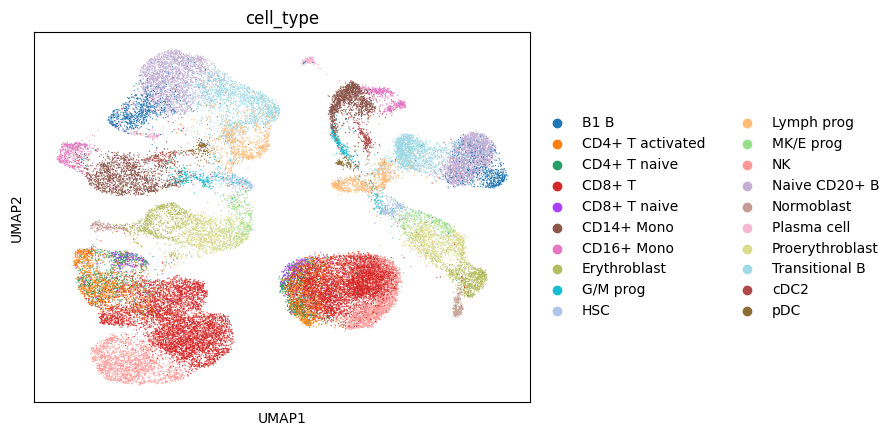

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


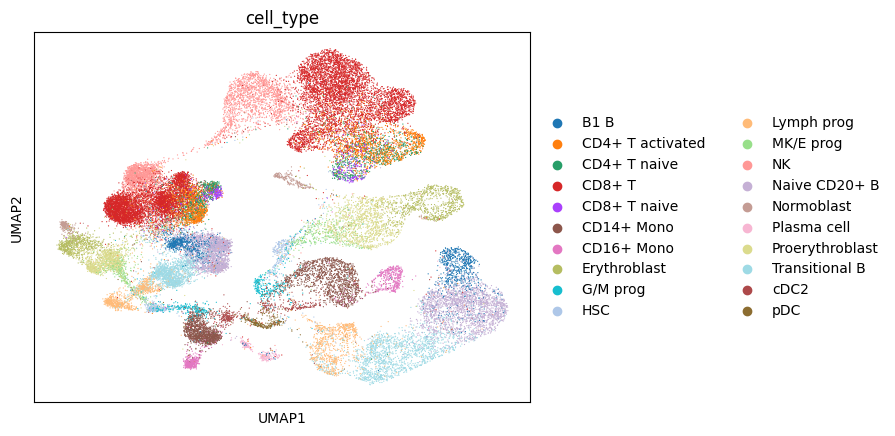

In [20]:
sc.pl.umap(ad_rna_concat, color=['cell_type'])
sc.pl.umap(ad_atac_concat, color=['cell_type'])

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


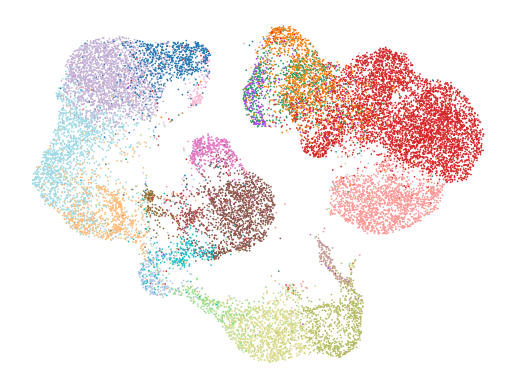

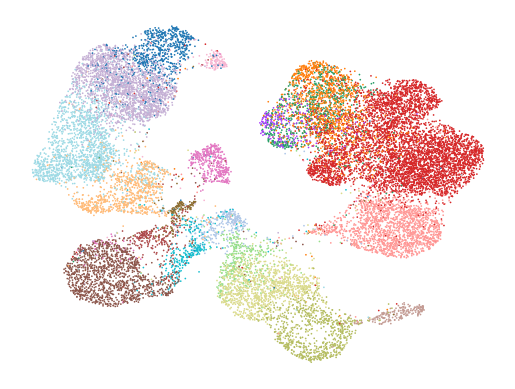

In [21]:
save_umap(ad_rna_imputed, 'X_umap', ['cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec3/umap', 
          prefix_name='MultiVI_Multiome_imputed-rna')
save_umap(ad_atac_imputed, 'X_umap', ['cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec3/umap', 
          prefix_name='MultiVI_Multiome_imputed-atac')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


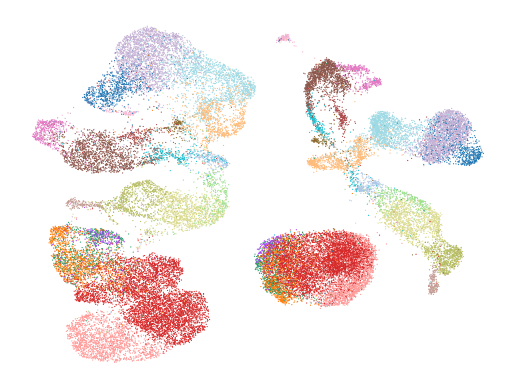

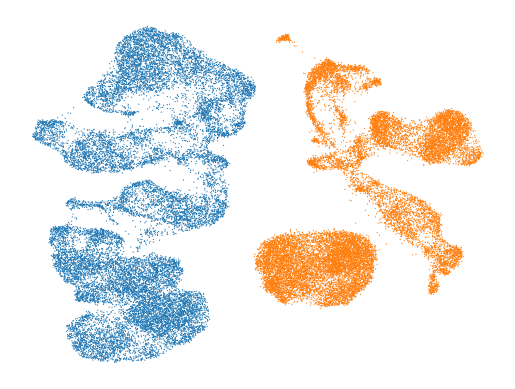

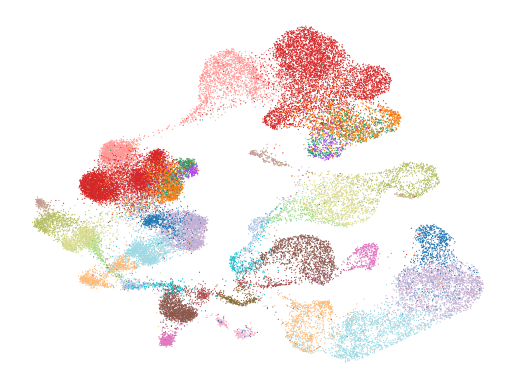

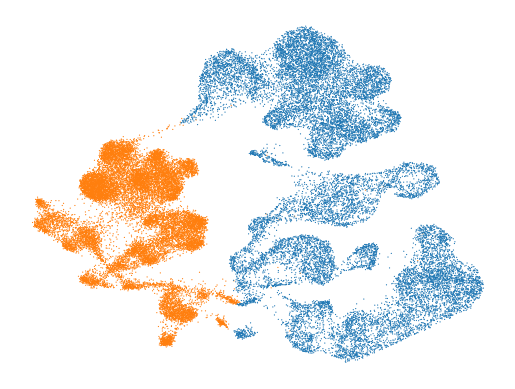

In [22]:
save_umap(ad_rna_concat, 'X_umap', ['cell_type', 'mod'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec3/umap', 
          prefix_name='MultiVI_Multiome_rna-gt-imputed-concat')
save_umap(ad_atac_concat, 'X_umap', ['cell_type', 'mod'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec3/umap', 
          prefix_name='MultiVI_Multiome_atac-gt-imputed-concat')